**Цель проекта:**

**Разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.**

**План работы:**

**1. Загрузка данных**

**2. Предобработка данных**

- **2.1. Анализ пропусков в столбцах, удаление строк с пропусками.**
- **2.2. Поиск аномальных значений.**
- **2.3. Удаление явных дубликатов.**
- **2.4. Приведение типов данных к нужному формату.**
- **2.5. Поиск и устранение неявных дубликатов.**

**3. Исследовательский анализ данных**

**3.1. Анализ распределений количественных и категориальных признаков.**

**4. Обучение разных моделей машинного обучения и поиск наилучшей по метрике ROC_AUC.**

**5. Оценка важности входных признаков.**

**5.1. Оценить важность признаков для лучшей модели и постройте график важности с помощью метода SHAP.**

 **5.2. Сделайте выводы о значимости признаков:**

-   **какие признаки мало значимы для модели;**
    
-   **какие признаки сильнее всего влияют на целевой признак;**
    
-   **как можно использовать эти наблюдения при моделировании и принятии бизнес-решений;**

**6. Сегментация покупателей**

**6.1. Выполнить сегментацию покупателей. Использовать результаты моделирования и данные о прибыльности покупателей.**

-   **Провести графическое и аналитическое исследование группы покупателей;**
    
-   **Сделать предложения по работе с сегментом для увеличения покупательской активности;**

**7. Итоговые выводы**

- **Подведение итогов проведенного исследования и выводы на основе полученных результатов.**

In [1]:
!pip install shap -q

!pip install scikit-learn==1.1.3 -q

!pip install phik -q

# Шаг 1. Загрузка данных

In [2]:
# Импортируем библиотеки 
import pandas as pd
import numpy as np
import shap
import seaborn as sns
import phik
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    LabelEncoder
) 

RANDOM_STATE=42
TEST_SIZE=0.25

In [3]:
market_file = pd.read_csv('/datasets/market_file.csv')
market_money = pd.read_csv('/datasets/market_money.csv')
market_time = pd.read_csv('/datasets/market_time.csv')
money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')

In [4]:
# Просмотр общей инофрматции датасета market_file
market_file.info()
market_file.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [5]:
market_file.describe()

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


In [6]:
# Просмотр общей инофрматции датасета market_money
market_money.info()
market_money.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [7]:
market_money.describe()

,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


In [8]:
# Просмотр общей инофрматции датасета market_time
market_time.info()
market_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [9]:
market_time.describe()

,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


In [10]:
# Просмотр общей инофрматции датасета money
money.info()
money.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [11]:
money.describe()

,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


**Все таблицы полностью заполнены, пропусков нет, что указывает на целостность предоставленных данных. Проверка типов данных показала, что они соответствуют требуемым для каждой колонки. Но стоит изменить названия столбцов, чтобы они были более удобные, для этого — все названия будут приведены к нижнему регистру. Кроме того, важно убедиться в отсутствии явных и неявных дубликатов в данных.**

# Шаг 2. Предобработка данных

In [12]:
# Функция для переименования столбцов в датафрейме.
def standardize_column_names(df):
    # Удаление пробелов, замена на подчеркивания и приведение к нижнему регистру
    df.columns = df.columns.str.replace(' ', '_').str.lower()

# Применяем функцию к каждому датафрейму
standardize_column_names(market_file)
standardize_column_names(market_money)
standardize_column_names(market_time)
standardize_column_names(money)

# Проверка результатов
print("Market File Columns:", market_file.columns)
print("Market Money Columns:", market_money.columns)
print("Market Time Columns:", market_time.columns)
print("Money Columns:", money.columns)



Market File Columns: Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')
Market Money Columns: Index(['id', 'период', 'выручка'], dtype='object')
Market Time Columns: Index(['id', 'период', 'минут'], dtype='object')
Money Columns: Index(['id', 'прибыль'], dtype='object')


**Поиск дубликатов**

In [13]:
# Проверяем на явные дубликаты
market_file.duplicated().sum()

0

In [14]:
# Проверяем на явные дубликаты
market_money.duplicated().sum()

0

In [15]:
# Проверяем на явные дубликаты
market_time.duplicated().sum()

0

In [16]:
# Проверяем на явные дубликаты
money.duplicated().sum()

0

In [17]:
# Список столбцов для проверки неявных дубликатов
columns_to_check = [
    'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
    'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
    'акционные_покупки', 'популярная_категория', 'средний_просмотр_категорий_за_визит',
    'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит'
]

# Поиск дубликатов по указанным столбцам
market_file[market_file.duplicated(subset=columns_to_check, keep=False)]



,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
337,215685,Снизилась,стандарт,нет,4.4,5,517,0.23,Товары для детей,1,2,5,11
338,215686,Снизилась,стандарт,нет,4.3,4,460,0.16,Техника для красоты и здоровья,2,1,3,6
339,215687,Снизилась,стандарт,да,3.9,4,627,0.24,Товары для детей,3,3,7,8
340,215688,Снизилась,стандарт,да,5.5,4,703,0.14,Мелкая бытовая техника и электроника,2,1,3,7
341,215689,Снизилась,стандарт,нет,5.0,4,136,0.27,Товары для детей,3,4,4,17
342,215690,Снизилась,стандарт,да,4.8,4,907,0.30,Косметика и аксесуары,2,1,1,6
343,215691,Снизилась,стандарт,нет,3.9,5,600,0.17,Домашний текстиль,1,7,4,10
344,215692,Снизилась,стандарт,да,3.3,3,871,0.20,Техника для красоты и здоровья,2,4,2,17
345,215693,Снизилась,стандарт,да,5.6,5,574,0.28,Домашний текстиль,3,2,3,9
346,215694,Снизилась,премиум,да,5.5,5,982,0.94,Мелкая бытовая техника и электроника,3,1,8,10


**В ходе первоначального анализа данных, мы обнаружили 11 неявных дубликатов, которые отличаются только значениями в столбце id, остальные данные у них идентичны. Явных дубликатов не найдено, а названия столбцов успешно приведены к стандартному виду. В настоящий момент, решено оставить эти неявные дубликаты в датасете для дальнейшего анализа.**

# Шаг 3. Исследовательский анализ данных

In [18]:
def plot_histogram_and_boxplot(data, column):
    # Устанавливаем размер фигуры 
    plt.figure(figsize=(10, 5))
    
    # Создаем гистограмму
    plt.subplot(1, 2, 1)
    sns.histplot(data[column], kde=True, color='darkcyan')
    plt.title(f'Распределение для "{column}"')
    plt.xlabel(f'Значения в {column}')
    plt.ylabel('Плотность')
    
    # Создаем диаграмму размаха
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[column], color='coral')
    plt.title(f'Boxplot для {column}')
    plt.xlabel(f'Значения в {column}')
    
    # Отображаем график
    plt.tight_layout(pad=2.0)
    plt.show()



In [19]:
def plot_countplot(data, column):
    # Устанавливаем размер графика
    plt.figure(figsize=(10, 5))
    
    # Строим countplot для дискретных признаков
    sns.countplot(data=data, x=column, palette="muted")
    plt.title(f'Распределение для "{column}"')
    plt.xlabel(f'Значения в {column}')
    plt.ylabel('Частота')
    
    # Отображаем график
    plt.tight_layout(pad=2.0)
    plt.show()


In [20]:
# Создаем список количественных столбцов датасета market_file
num_col_market = [
    'маркет_актив_6_мес',  
    'длительность', 
    'акционные_покупки'
]

In [21]:
# Создаем список дискретных столбцов датасета market_file
discrete_columns = [
    'средний_просмотр_категорий_за_визит', 
    'неоплаченные_продукты_штук_квартал', 
    'ошибка_сервиса', 
    'страниц_за_визит',
    'маркет_актив_тек_мес'
]


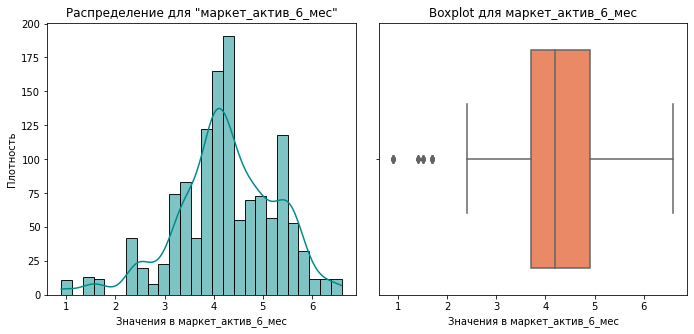

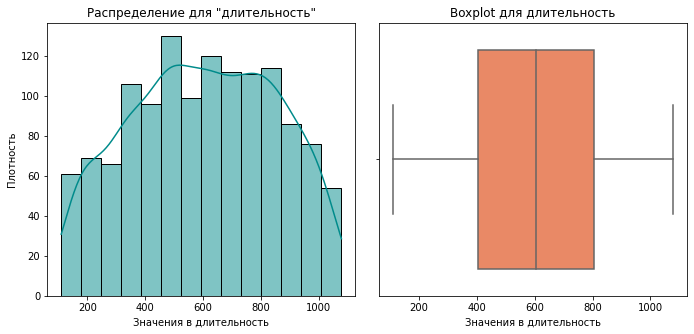

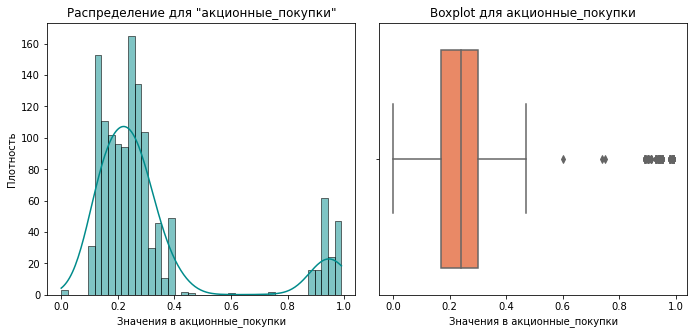

In [22]:
# Построение распределений количественных признаков датасета market_file
for name in num_col_market:
    plot_histogram_and_boxplot(market_file, name)

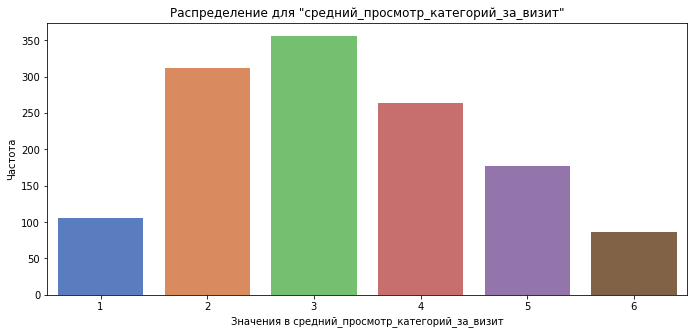

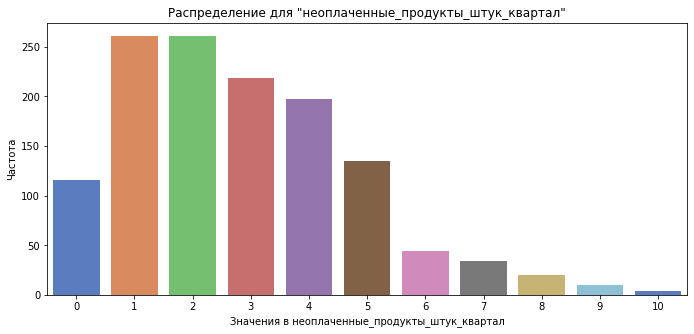

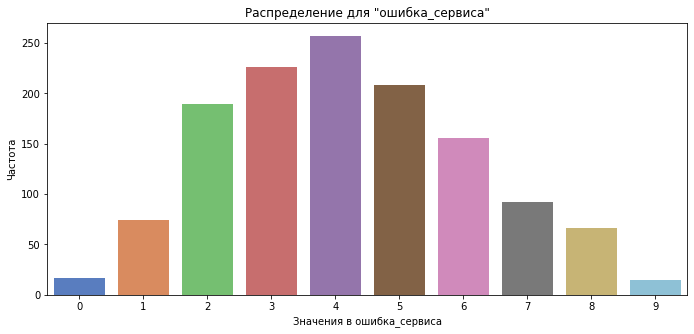

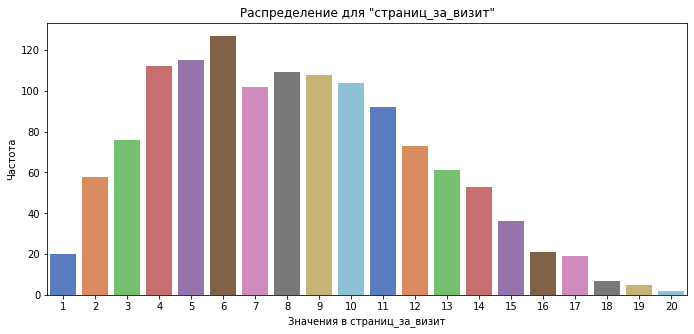

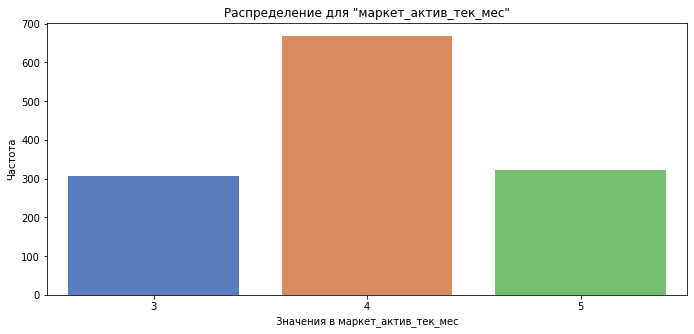

In [23]:
# Построение графиков для дискретных признаков
for name in discrete_columns:
    plot_countplot(market_file, name)


- **Маркет-актив-6-мес: Признак маркет-актив-6-мес имеет нормальное распределение, с небольшим правосторонним скосом. Большинство значений сосредоточено в диапазоне от 3 до 5. На боксплоте видны выбросы в области низких значений (от 1 до 2). Эти выбросы могут быть редкими случаями пользователей, которые почти не получают маркетинговых коммуникаций, и их возможно надо будет исключить. В боксплоте видно, что медиана находится около значения 4, нижний квартиль (Q1) близок к значению 3, а верхний квартиль (Q3) приближается к значению 5. Это означает, что 50% пользователей получают от 3 до 5 взаимодействий. Несмотря на наличие выбросов внизу, распределение имеет правосторонний хвост, что говорит о том, что небольшое количество пользователей получают больше маркетинговых взаимодействий, что может указывать на высокую вовлеченность этих клиентов.**

- **Маркет_актив_тек_мес: Исходя из графика распределения для признака "маркет_актив_тек_мес", видно, что большинство пользователей имеют значение маркетинговой активности, равное 4, что составляет наибольшую группу. Менее активные пользователи (с показателем 3) и более активные (с показателем 5) встречаются реже.**

- **Длительность: Признак длительность имеет нормальное распределение с незначительным правосторонним скосом. Большинство значений находятся в диапазоне от 400 до 800,это говорит о том, что большинство пользователей зарегистрированы на сайте в течение этого промежутка времени. Диаграмма размаха показывает, что медиана расположена около значения 600 дней. Нижний квартиль (Q1) составляет около 400 дней, а верхний квартиль (Q3) приближается к 800 дням. В данном признаке не наблюдаю значимых выбросов. В общем, этот признак выглядит достаточно хорошо распределенным с небольшим правосторонним скосом, и его можно использовать без значительных преобразований или обработки.**

- **Акционные_покупки: Признак акционные_покупки имеет бимодальное распределение с двумя основными пиками: первый пик расположен около значения 0.2, а второй — ближе к 1. В боксплоте четко видны выбросы для значений выше 0.6, которые свидетельствуют о том, что небольшая часть покупателей делает почти все свои покупки по акциям. Бимодальность распределения указывает на разную покупательскую стратегию у разных групп клиентов. Клиенты, находящиеся в правой части распределения, больше ориентированы на акции, нужно обратить на них внимание.**

- **Средний_просмотр_категорий_за_визит: На графике распределения признака средний_просмотр_категорий_за_визит видно, что большинство пользователей просматривают в среднем 2–4 категории за визит, что составляет основные пики распределения. Наибольшая частота наблюдается у значения 3, это значит, что для большинства пользователей данный показатель является средним. Значения 1 и 6 встречаются реже, что говорит о наличии меньшей группы пользователей, которые либо промсматривают совсем мало категорий, либо, наоборот, проявляют повышенную активность, просматривая больше категорий за визит.**

- **Неоплаченные_продукты_штук_квартал: На графике распределения признака неоплаченные_продукты_штук_квартал видно, что большинство пользователей оставляют в корзине от 1 до 4 товаров в течение квартала. Наибольшая частота наблюдается для значений 1 и 2, это свидетельствует о том, что основная масса пользователей оставляет в корзине небольшое количество товаров. При этом наблюдаются пользователи, которые оставляют в корзине до 5–6 товаров, а отдельные редкие случаи показывают значения вплоть до 10. Такое распределение означает о необходимости работать с пользователями, оставляющими в корзине большое количество товаров, чтобы стимулировать их к завершению покупок.**

- **Ошибка_сервиса: На графике распределения признака ошибка_сервиса видно, что большинство пользователей сталкиваются с 3-5 ошибками при взаимодействии с сервисом. Самая частая ошибка — это 4 ошибки, что очень много для среднего количество проблем, с которыми сталкиваются пользователи. Существуют также пользователи, у которых ошибки варьируются от 1 до 9, но их значительно меньше. Наличие ошибок негативно влияет на пользовательский опыт, поэтому для улучшения сервиса следует обращать внимание на пользователей с большим количеством ошибок, так как они будут склонны к снижению активности из-за неудовлетворенности сервисом.**

- **Страниц_за_визит: На графике распределения признака страниц_за_визит видно, что большая часть пользователей просматривает от 4 до 8 страниц за визит, с пиком на уровне 6 страниц. Это говорит о том, что большинство пользователей активно исследуют несколько страниц во время одного визита. Однако есть пользователи, которые просматривают как меньшее количество страниц (от 1 до 3), так и большее (до 20), хотя таких пользователей значительно меньше.**

In [24]:
# Создаем список количественных столбцов датасета market_money
num_col_market_money = ['выручка'] 

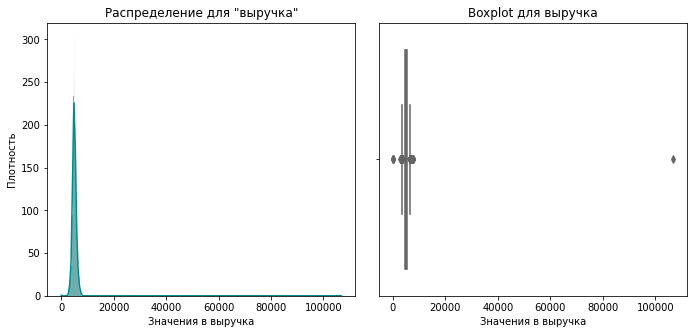

In [25]:
# Построение распределений количественных признаков датасета market_money
for name in num_col_market_money:
    plot_histogram_and_boxplot(market_money, name)

In [26]:
market_money.query('выручка > 20000')

,id,период,выручка
98,215380,текущий_месяц,106862.2


**Есть одно аномально высокое значение выручки за текущий месяц. Это значение следует исключить.**

In [27]:
# Находим пользователей с аномальной выручкой
delete_users = market_money[market_money['выручка'] > 20000]['id'].unique()

# Удаляем таких пользователей
market_money = market_money[~market_money['id'].isin(delete_users)]


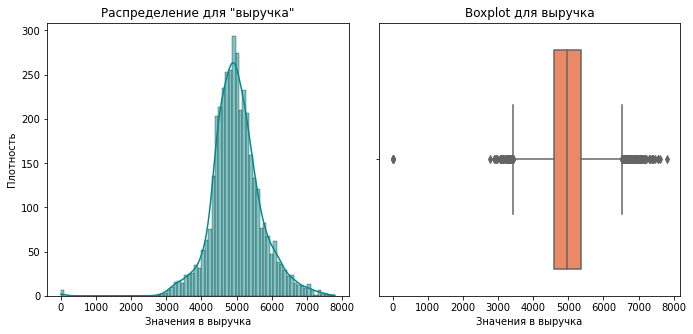

In [28]:
# Построение распределений количественных признаков датасета market_money без выбросов
for name in num_col_market_money:
    plot_histogram_and_boxplot(market_money, name)

In [29]:
# Создаем список количественных столбцов датасета market_time
num_col_market_time = ['минут'] 

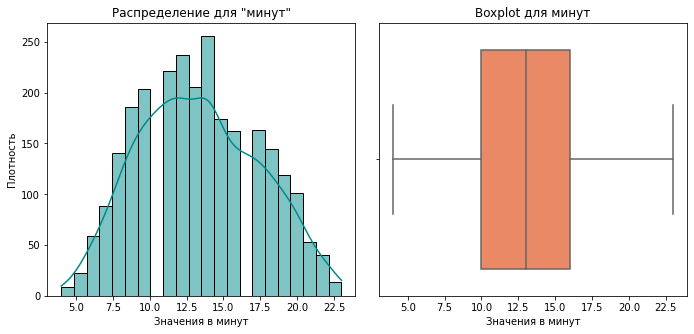

In [30]:
# Построение распределений количественных признаков датасета time
for name in num_col_market_time:
    plot_histogram_and_boxplot(market_time, name)

**Признак минуты имеет нормальное распределение.**

In [31]:
# Создаем список количественных столбцов датасета money
num_col_money = ['прибыль'] 

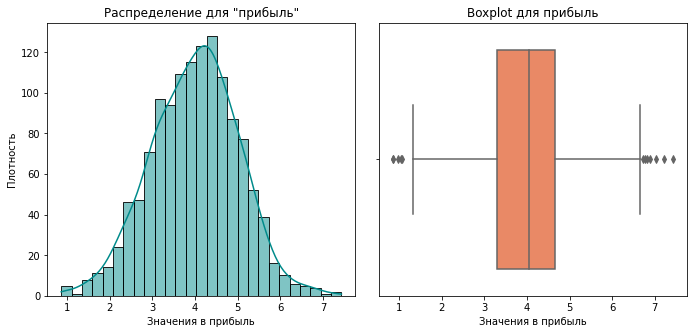

In [32]:
# Построение распределений количественных признаков датасета money
for name in num_col_money:
    plot_histogram_and_boxplot(money, name)

**Этот признак также имеет нормальное распределение.**

In [33]:
def plot_categorical(data, column):
    # Отображаем уникальные значения признака
    unique_values = data[column].nunique()
    display(f'Количество уникальных значений в {column}:', unique_values)
    display(data[column].value_counts())

    # Устанавливаем размер фигуры 
    plt.figure(figsize=(12, 6))
    
    # Строим barplot для категориального признака 
    plt.subplot(1, 2, 1)
    sns.barplot(x=data[column].value_counts().values, y=data[column].value_counts().index, palette="Spectral")
    plt.title(f'Распределение значений "{column}"', fontsize=15, weight='bold')
    plt.xlabel('Частота', fontsize=12)
    plt.ylabel(f'{column}', fontsize=12)
    
    # Подгоняем параметры отображения
    plt.tight_layout(pad=3.0)
    plt.show()


In [34]:
# Создаем список категориальных признаков датасета market_file
cat_col_market_file = ['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'популярная_категория']


In [35]:
# В ходе построения графиков была обнаружена опечатка
market_file['тип_сервиса'] = market_file['тип_сервиса'].replace('стандартт', 'стандарт')

'Количество уникальных значений в покупательская_активность:'

2

Прежний уровень    802
Снизилась          498
Name: покупательская_активность, dtype: int64

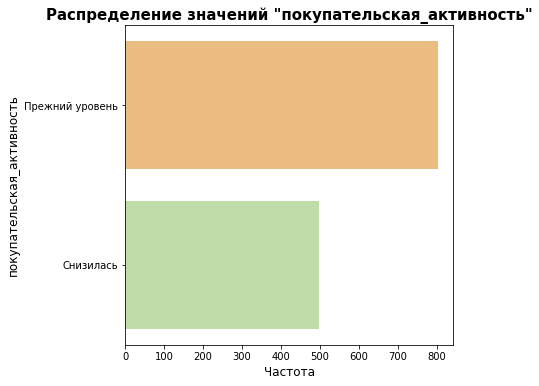

'Количество уникальных значений в тип_сервиса:'

2

стандарт    924
премиум     376
Name: тип_сервиса, dtype: int64

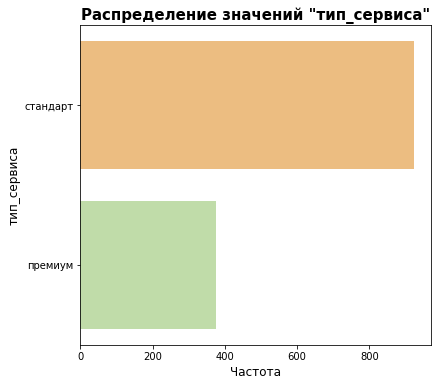

'Количество уникальных значений в разрешить_сообщать:'

2

да     962
нет    338
Name: разрешить_сообщать, dtype: int64

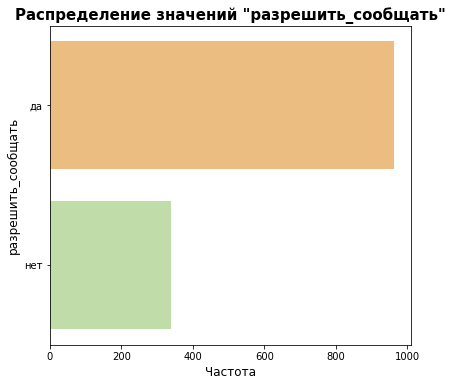

'Количество уникальных значений в популярная_категория:'

6

Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: популярная_категория, dtype: int64

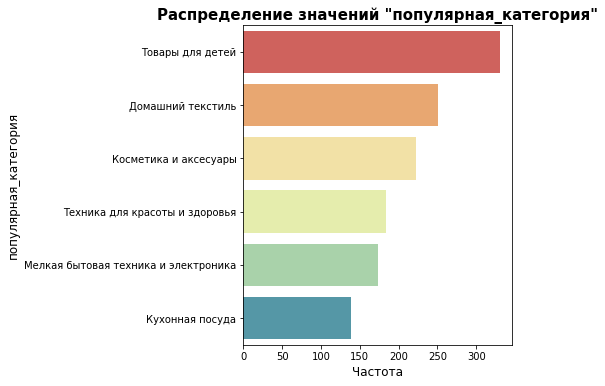

In [36]:
# Применение функции plot_categorical для всех категориальных признаков
for column in cat_col_market_file:
    plot_categorical(market_file, column)


**Покупательская активность: Наблюдается определённый дисбаланс в распределении значений целевого признака, что следует учесть при построении модели. Тип сервиса: Пользователей премиум-сервиса меньше, чем стандартных.**

In [37]:
# Создаем список категориальных признаков датасета market_money
cat_col_market_money = ['период']

'Количество уникальных значений в период:'

3

предыдущий_месяц       1299
препредыдущий_месяц    1299
текущий_месяц          1299
Name: период, dtype: int64

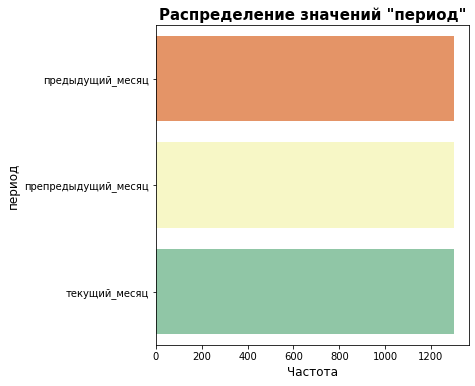

In [38]:
# Применение функции plot_categorical для всех категориальных признаков
for column in cat_col_market_money:
    plot_categorical(market_money, column)

**Признак распределен равномерно, странных значений нет.**

In [39]:
# Создаем список категориальных признаков датасета market_time
cat_col_market_time = ['период']

In [40]:
# В ходе построения графиков была обнаружена опечатка
market_time['период'] = market_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

'Количество уникальных значений в период:'

2

предыдущий_месяц    1300
текущий_месяц       1300
Name: период, dtype: int64

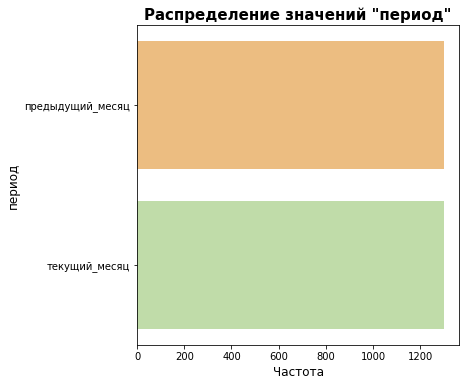

In [41]:
# Применение функции plot_categorical для всех категориальных признаков
for column in cat_col_market_time:
    plot_categorical(market_time, column)

**Признак имеет нормальное распределение**

# Выбор активных покупателей

**Необходимо отобрать клиентов, которые были активны не менее трёх месяцев. Для этого нам потребуются записи из таблицы market_money, где у клиента зафиксированы покупки за все три периода: "препредыдущий месяц", "текущий месяц" и "предыдущий месяц".**

In [42]:
# Создаем словарь агрегации для подсчета количества записей по каждому 'id'
m_dict = {'период': 'count'}

# Группируем данные по 'id' и подсчитываем количество записей для каждого
grouped_data = market_money.groupby('id').agg(m_dict)

# Переименовываем столбец для ясности
grouped_data.columns = ['entry_count']

# Оставляем пользователей, у которых записи есть не за все три периода
all_periods = grouped_data[grouped_data['entry_count'] < 3]

# Фильтруем таблицу market_money по id таких пользователей и пользователей с нулевой выручкой
filtered_market_money = market_money[market_money['id'].isin(all_periods.index) | (market_money['выручка'] == 0)]

# Получаем список неактивных пользователей
inactive_users_auto = filtered_market_money['id'].unique().tolist()

# Объединяем списки неактивных пользователей и пользователей с аномальной выручкой
all_delete_users = list(set(inactive_users_auto + delete_users.tolist()))
all_delete_users

[215348, 215357, 215380, 215359]

In [43]:
# Фильтруем таблицы, исключая пользователей из объединенного списка
market_file_filtered = market_file[~market_file['id'].isin(all_delete_users)]
market_money_filtered = market_money[~market_money['id'].isin(all_delete_users)]
market_time_filtered = market_time[~market_time['id'].isin(all_delete_users)]
money_filtered = money[~money['id'].isin(all_delete_users)]

# Выводим размер каждой таблицы
print(f"market_file: {market_file_filtered.shape[0]} записей")
print(f"market_money: {market_money_filtered.shape[0]} записей")
print(f"market_time: {market_time_filtered.shape[0]} записей")
print(f"money: {money_filtered.shape[0]} записей")

market_file: 1296 записей
market_money: 3888 записей
market_time: 2592 записей
money: 1296 записей


**Отфильтровали четырех пользователей.**

**На этом этапе был выполнен исследовательский анализ данных. В процессе удалось обнаружить и исправить некоторые опечатки, выявленные при визуальном анализе графиков. В целом, данные оказались достаточно чистыми. Также были оставлены только те пользователи, которые совершали покупки в течение последних трёх месяцев.**

# Объединение таблиц

**Объеденим данные из датафреймов market_file, market_money, market_time в одну таблицу.**

In [44]:
# Создаем сводные таблицы для выручки и времени по каждому клиенту из отфильтрованных данных
market_money_grouped = market_money_filtered.pivot_table(index=['id'], columns=["период"])
market_money_grouped.columns = ['выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']
market_money_grouped['id'] = market_money_grouped.index

market_time_grouped = market_time_filtered.pivot_table(index=['id'], columns=["период"])
market_time_grouped.columns = ['минут_предыдущий_месяц', 'минут_текущий_месяц']
market_time_grouped['id'] = market_time_grouped.index

# Присоединяем данные выручки и времени к отфильтрованной таблице market_file
market_full = market_file_filtered.join(market_money_grouped, on='id', lsuffix="_left", rsuffix="_выручка")
market_full = market_full.rename(columns={'id_left':'id'})
market_full = market_full.join(market_time_grouped, on='id', lsuffix="_left", rsuffix="_минут")
market_full = market_full.rename(columns={'id_left':'id'})


market_full = market_full.drop(['id_выручка', 'id_минут'], axis=1)

market_full.head(5)




,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


**Теперь все данные в одной таблице**

# Корреляционный анализ

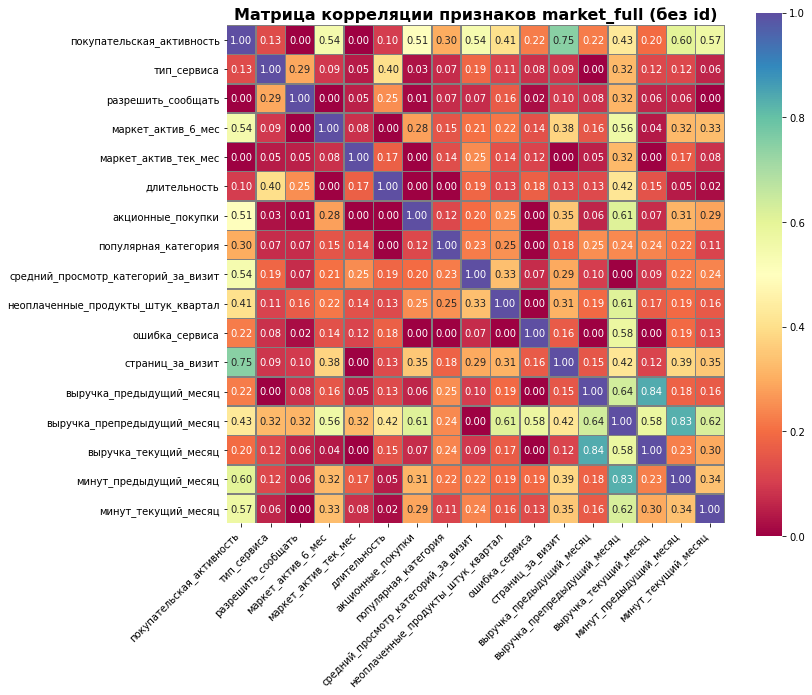

In [45]:
# Удаляем признак id из данных для корреляционного анализа
market_full_no_id = market_full.drop(columns=['id'])

# Задаем список непрерывных признаков
interval_cols = [
    'маркет_актив_6_мес', 
    'длительность', 
    'акционные_покупки', 
    'выручка_предпредыдущий_месяц', 
    'выручка_предыдущий_месяц', 
    'выручка_текущий_месяц'
]

# Вычисляем PHIK корреляционную матрицу с указанием непрерывных признаков
corr_matrix = market_full_no_id.phik_matrix(interval_cols=interval_cols)

# Создаем фигуру и оси для визуализации
fig, ax = plt.subplots(figsize=(12, 10))

# Настраиваем тепловую карту
sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap='Spectral', 
    linewidths=0.5, 
    linecolor='gray',  
    square=True,
    ax=ax
)

# Устанавливаем заголовок
plt.title('Матрица корреляции признаков market_full (без id)', fontsize=16, fontweight='bold')

# Настройка положения меток осей
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()



**Вывод:**

- **Взаимосвязь маркетинговых активностей и покупательской активности имеет среднюю корреляцию, что подтверждает важность маркетинговых коммуникаций для поддержания активности покупателей.**

- **Выручка и время, проведенное на сайте, демонстрируют очевидную закономерность: чем больше времени пользователи проводят на сайте, тем выше их расходы.**

**Эти выводы могут помочь в дальнейшем сегментировании клиентов и разработке стратегии для повышения покупательской активности.**

# Шаг 4. Выбор лучшей модели МО

count    1296.000000
mean        0.320069
std         0.249159
min         0.110000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: акционные_покупки, dtype: float64


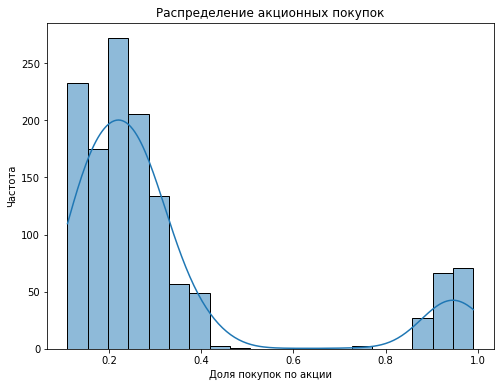

In [46]:
# Анализ распределения значений акционных покупок
print(market_full['акционные_покупки'].describe())

# Визуализация распределения
plt.figure(figsize=(8,6))
sns.histplot(market_full['акционные_покупки'], bins=20, kde=True)
plt.title('Распределение акционных покупок')
plt.xlabel('Доля покупок по акции')
plt.ylabel('Частота')
plt.show()

# Преобразование категориального признака 'акционные_покупки'
market_full['категория_акционных_покупок'] = market_full['акционные_покупки'].apply(
    lambda x: 'Часто покупает по акции' if x >= 0.5 else 'Редко покупает по акции'
)




**Исходя из графика распределения акционных покупок, видно, что большинство пользователей совершают менее 50% своих покупок по акциям, а лишь небольшая группа делает более 50% покупок по акции.**

**Порог в 0.5 для разделения на категории выглядит обоснованным, так как разделяет эти две группы:**

- **Пользователи, которые совершают менее половины своих покупок по акциям (большая доля акционных покупок менее 0.5).**


- **Пользователи, которые совершают более половины своих покупок по акциям (меньшая доля акционных покупок около 1.0).**

In [47]:
# Удаление исходного количественного признака 
market_full.drop(columns=['акционные_покупки'], inplace=True)


market_full.set_index('id', inplace=True)


market_full.head()

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,категория_акционных_покупок
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,Часто покупает по акции
215350,Снизилась,стандарт,нет,4.9,3,539,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13,Редко покупает по акции
215351,Снизилась,стандарт,да,3.2,5,896,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,Часто покупает по акции
215352,Снизилась,стандарт,нет,5.1,3,1064,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,Часто покупает по акции
215353,Снизилась,стандарт,да,3.3,4,762,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10,Редко покупает по акции


In [48]:
# Разделим на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    market_full.drop(['покупательская_активность'], axis=1), 
    market_full['покупательская_активность'],  
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE,
    stratify=market_full['покупательская_активность'] 
)

# Кодирование целевого признака с помощью LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)


In [49]:
ohe_columns = ['популярная_категория']
ord_columns = ['категория_акционных_покупок', 'разрешить_сообщать', 'тип_сервиса']

In [50]:
num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
               'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 
               'ошибка_сервиса', 'страниц_за_визит', 'выручка_предыдущий_месяц', 
               'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 
               'минут_предыдущий_месяц', 'минут_текущий_месяц']


In [51]:
ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
])

In [52]:
ord_pipe = Pipeline([
    ('simple_imputer_ord_before', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('simple_imputer_ord_after', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

In [53]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)], 
    remainder='passthrough'
)

In [54]:
# Pipeline для модели
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=42))
])


In [55]:
param_grid = [
    # словарь для модели DecisionTreeClassifier
    {
        'models': [DecisionTreeClassifier(random_state=42)],
        'models__max_depth': range(2, 7),
        'models__max_features': range(2,7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели KNeighborsClassifier
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    # словарь для модели LogisticRegression
    {
        'models': [LogisticRegression(random_state=42, solver='liblinear', penalty='l1')],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC
    {
        'models': [SVC(random_state=42, kernel='poly', probability=True)],
        'models__degree': range(2, 3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]


In [56]:
# GridSearch для поиска лучшей модели
grid = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1
)

**Метрику ROC-AUC выбрали для оценки моделей, так как она хорошо подходит для задач классификации, особенно в условиях возможного дисбаланса классов. В нашем случае важно предсказать вероятность снижения покупательской активности, и ROC-AUC позволяет оценить, насколько модель различает активных и неактивных пользователей. Кроме того, ROC-AUC подходит для моделей, которые возвращают вероятности, а это то что нам нужно в данном проекте.**

In [57]:
# Обучение модели на тренировочной выборке
grid.fit(X_train, y_train)

# Вывод лучшей модели
print('Лучшая модель и её параметры:\n\n', grid.best_params_)

Лучшая модель и её параметры:

 {'models': LogisticRegression(C=1, penalty='l1', random_state=42, solver='liblinear'), 'models__C': 1, 'preprocessor__num': MinMaxScaler()}


In [58]:
print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)
print ('Метрика лучшей модели с помощью кросс-валидации:', grid.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simple_imputer_ord_before',
                 

In [59]:
y_test_pred = grid.predict(X_test)
y_test_proba = grid.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_proba[:,1])}')

Метрика ROC-AUC на тестовой выборке: 0.9180924645067345


In [60]:
# Создаем константную модель
dummy_model = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)


dummy_model.fit(X_train, y_train)

y_pred_dummy = dummy_model.predict(X_test)


dummy_roc_auc = roc_auc_score(y_test, y_pred_dummy)

# Выводим результат
print(f'Метрика ROC-AUC для константной модели: {dummy_roc_auc}')

Метрика ROC-AUC для константной модели: 0.5


- **Результат тестирования нашей модели на тествой выборке лучше, чем результат константной модели.**

**На данном этапе исследования была разработана и обучена модель для предсказания снижения активности клиентов сервиса. Наилучшие результаты продемонстрировала модель LogisticRegression с параметрами C=1, penalty='l1', random_state=42, и solver='liblinear'. Метрика ROC-AUC для тестовой выборки составила 0.92, а с помощью кросс-валидации — 0.89.**

# Шаг 5. Анализ важности признаков

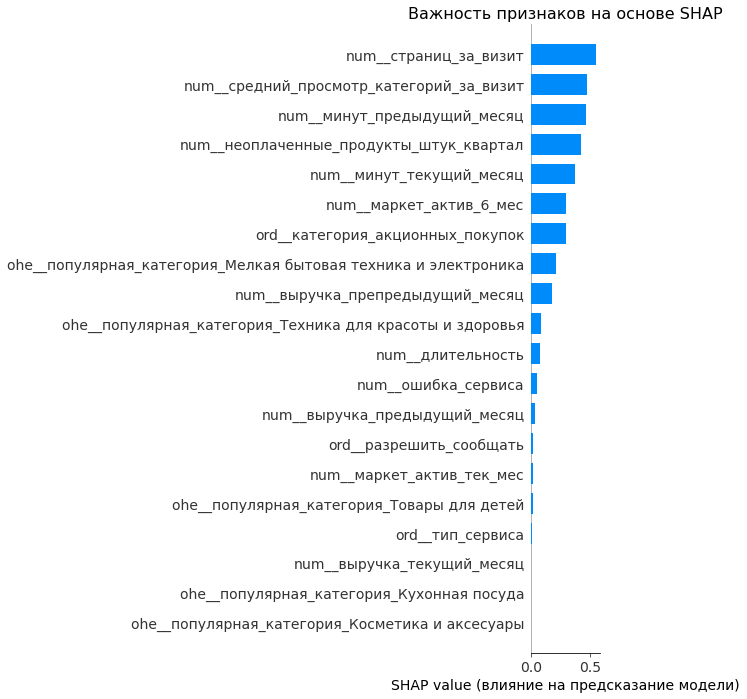

In [61]:
# Получаем трансформированные признаки
X_encoded = grid.best_estimator_['preprocessor'].fit_transform(X_train)

# Получаем названия признаков 
labels = grid.best_estimator_['preprocessor'].get_feature_names_out()

model_ = grid.best_estimator_['models'].fit(X_encoded, y_train)
explainer_ = shap.Explainer(model_, X_encoded)
shap_values = explainer_(X_encoded)
shap.summary_plot(shap_values.values, X_encoded, plot_type='bar', feature_names=labels, show=False)
fig, ax = plt.gcf(), plt.gca()

# Подписываем оси графика
ax.tick_params(labelsize=14)
ax.set_xlabel("SHAP value (влияние на предсказание модели)", fontsize=14)
ax.set_title('Важность признаков на основе SHAP', fontsize=16)

plt.show()



**Согласно графику SHAP, наиболее важными признаками для предсказания модели оказались количество страниц, которые клиент просматривает за визит, и средний просмотр категорий. Что логично, поскольку чем больше категорий и страниц пользователь просматривает, тем активнее он взаимодействует с платформой. Также существенное влияние оказывают такие показатели, как количество минут, проведенных на сайте в предыдущем месяце, и количество неоплаченных товаров в корзине за квартал. Это гооврит о том, что пользователи, которые дольше находятся на сайте и чаще оставляют товары неоплаченными, склонны к снижению активности. Примечательно, что такие признаки, как маркетинговая активность и акционные покупки, оказались менее значимыми для модели. В то же время категория сервиса и разрешение на получение сообщений также сыграли небольшую роль, что дает понять, что эти параметры не так сильно влияют на предсказание изменения активности пользователей.**

**Признаки, такие как количество страниц за визит и средний просмотр категорий, показывают, что вовлеченность пользователей является ключевым фактором их активности. Необходимо создавать контент, который будет стимулировать пользователей просматривать больше страниц и категорий, возможно, через персонализацию рекомендаций или улучшение пользовательского опыта на сайте. Наличие неоплаченных товаров в корзине также является важным фактором, нужно обратить внимание на оптимизацию процесса оплаты или предложении дополнительных скидок или персонализированных предложений для завершения покупок.**

# Шаг 6.Сегментация покупателей

In [62]:
# Прогнозирование вероятностей снижения покупательской активности для тестовой выборки
test_probabilities = grid.predict_proba(X_test)[:, 1]
train_probabilities = grid.predict_proba(X_train)[:, 1]

# Создаем копии добавления вероятностей
X_test_with_probs = X_test.copy()
X_train_with_probs = X_train.copy()

# Добавляем столбец с вероятностью снижения активности
X_test_with_probs['вероятность_снижения_активности'] = test_probabilities
X_train_with_probs['вероятность_снижения_активности'] = train_probabilities

# Объединяем тренировочные и тестовые данные
df_combined = pd.concat([X_train_with_probs, X_test_with_probs])

# Устанавливаем индекс в таблице с данными о прибыли по идентификатору клиента
money = money.set_index('id')

# Объединяем таблицы с данными
df_combined = df_combined.join(money, on='id')

df_combined.head()


,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,категория_акционных_покупок,вероятность_снижения_активности,прибыль
id,,,,,,,,,,,,,,,,,,
215858,стандарт,да,5.5,4,510,Мелкая бытовая техника и электроника,2,4,7,16,5170.5,4347.0,6014.2,20,6,Редко покупает по акции,0.074825,4.37
215361,стандарт,да,5.1,4,199,Техника для красоты и здоровья,4,5,2,3,6400.0,4597.0,3789.7,11,13,Редко покупает по акции,0.574202,4.03
215884,стандарт,да,4.3,5,997,Мелкая бытовая техника и электроника,5,1,3,11,4113.0,4626.0,3798.4,13,10,Редко покупает по акции,0.069694,4.37
216564,стандарт,да,5.6,4,342,Кухонная посуда,2,7,5,8,4930.0,5269.0,4766.2,14,19,Часто покупает по акции,0.699471,5.58
215715,премиум,да,3.6,5,873,Товары для детей,3,2,2,5,3716.0,4691.0,4600.0,10,10,Редко покупает по акции,0.739791,4.87


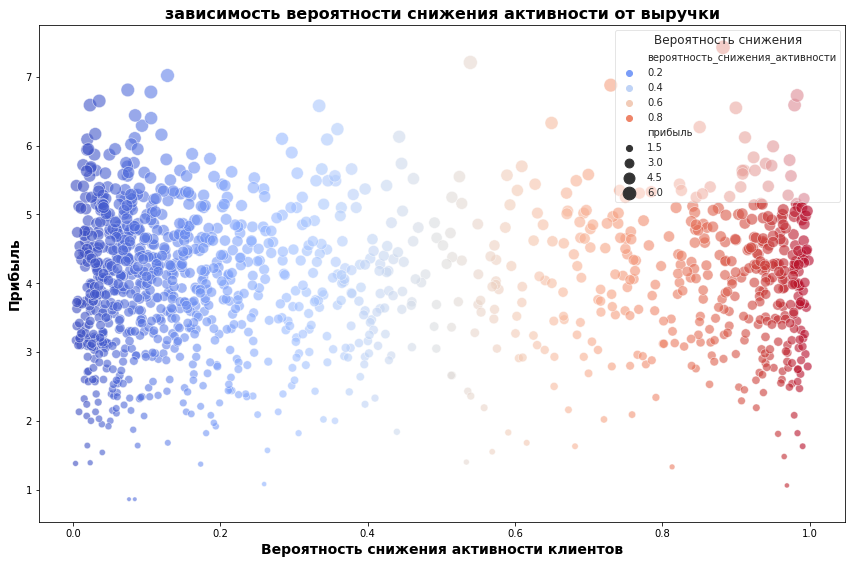

In [63]:
# Настраиваем размеры графика и стиль
fig, ax = plt.subplots(figsize=(12, 8))
sns.set(style="whitegrid")

# Используем scatterplot для отображения зависимости вероятности снижения активности от прибыли
scatter = sns.scatterplot(
    data=df_combined, 
    x='вероятность_снижения_активности', 
    y='прибыль', 
    hue='вероятность_снижения_активности', 
    palette='coolwarm', 
    size='прибыль', 
    sizes=(20, 200),
    alpha=0.6,
    ax=ax
)

# Настройка осей и заголовков
ax.set_xlabel('Вероятность снижения активности клиентов', fontsize=14, weight='bold')
ax.set_ylabel('Прибыль', fontsize=14, weight='bold')
ax.set_title('зависимость вероятности снижения активности от выручки', fontsize=16, weight='bold')
legend = ax.legend(title="Вероятность снижения", loc='upper right', fontsize='small', framealpha=0.5)  # Изменение прозрачности и размера легенды

plt.tight_layout()
plt.show()



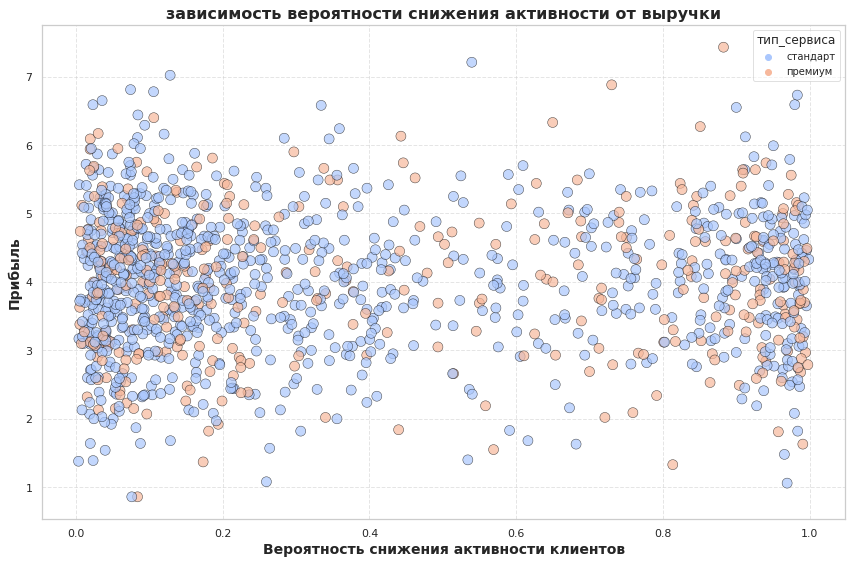

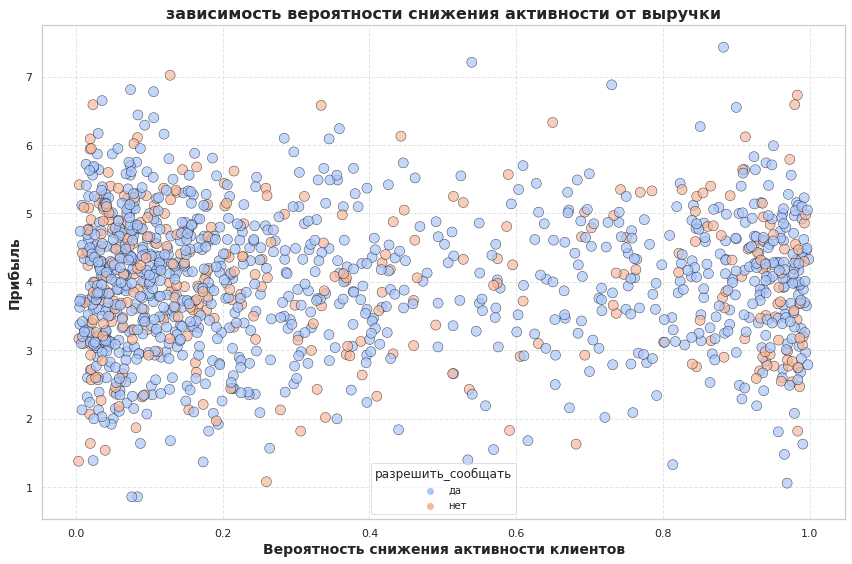

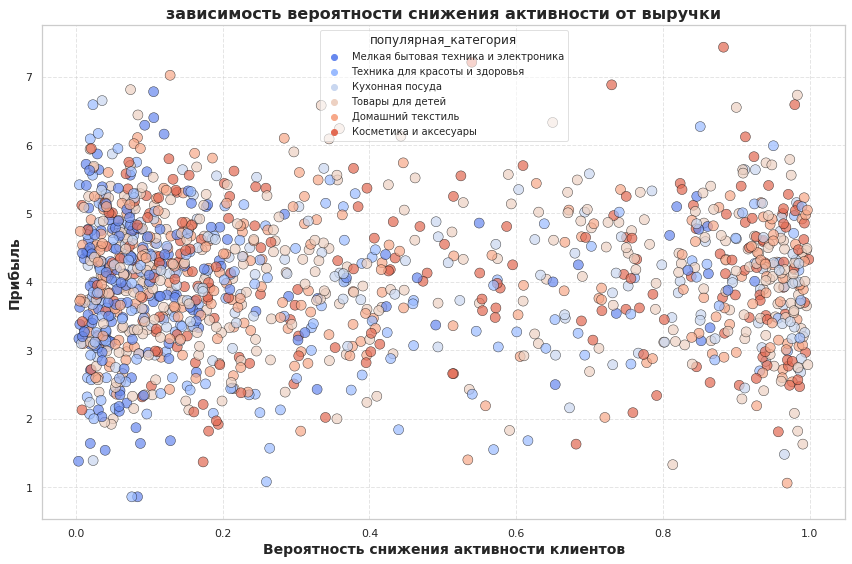

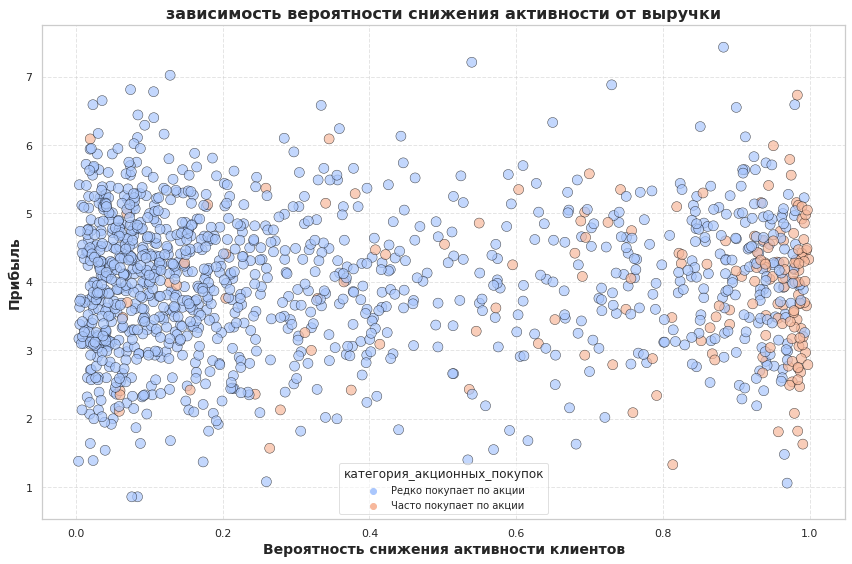

In [64]:
def plot_scatter_for_categories(cat_columns):
    # Проходим по каждому категориальному признаку
    for cat_col in cat_columns:
        plt.figure(figsize=(12, 8))
        
        # Создаем scatterplot
        scatter = sns.scatterplot(
            data=df_combined, 
            x='вероятность_снижения_активности', 
            y='прибыль', 
            hue=cat_col, 
            palette='coolwarm',  
            alpha=0.7, 
            s=100, 
            edgecolor='black', 
            linewidth=0.5 
        )

        # Настраиваем оси и заголовки
        plt.xlabel('Вероятность снижения активности клиентов', fontsize=14, weight='bold')
        plt.ylabel('Прибыль', fontsize=14, weight='bold')
        plt.title(f'зависимость вероятности снижения активности от выручки', fontsize=16, weight='bold')
        plt.legend(title=cat_col, loc='best', fontsize='small', framealpha=0.6)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()


categorical_columns = df_combined.select_dtypes(include='object').columns.tolist()

plot_scatter_for_categories(categorical_columns)




In [65]:
# Добавление сегмента для пользователей на основе условий
df_combined['сегмент'] = df_combined.apply(
    lambda x: 'Целевой сегмент' if (x['вероятность_снижения_активности'] > 0.8) and 
                                  (x['категория_акционных_покупок'] == 'Часто покупает по акции') 
    else 'Другие клиенты', axis=1
)


In [66]:
# Выбор только числовых столбцов из df_combined
num_df = df_combined.select_dtypes(include='number')


,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,вероятность_снижения_активности,прибыль
id,,,,,,,,,,,,,,
215858,5.5,4,510,2,4,7,16,5170.5,4347.0,6014.2,20,6,0.074825,4.37
215361,5.1,4,199,4,5,2,3,6400.0,4597.0,3789.7,11,13,0.574202,4.03
215884,4.3,5,997,5,1,3,11,4113.0,4626.0,3798.4,13,10,0.069694,4.37
216564,5.6,4,342,2,7,5,8,4930.0,5269.0,4766.2,14,19,0.699471,5.58
215715,3.6,5,873,3,2,2,5,3716.0,4691.0,4600.0,10,10,0.739791,4.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215429,0.9,4,690,2,5,7,4,3662.0,4488.0,4158.6,11,10,0.959621,3.71
216233,3.9,4,1048,3,0,6,14,4325.0,4553.0,4257.4,15,17,0.051012,4.62
215716,2.4,4,952,3,5,2,3,3067.0,4165.0,3343.9,13,14,0.845530,4.07


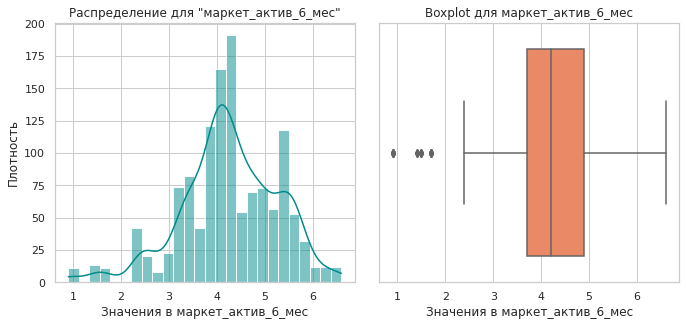

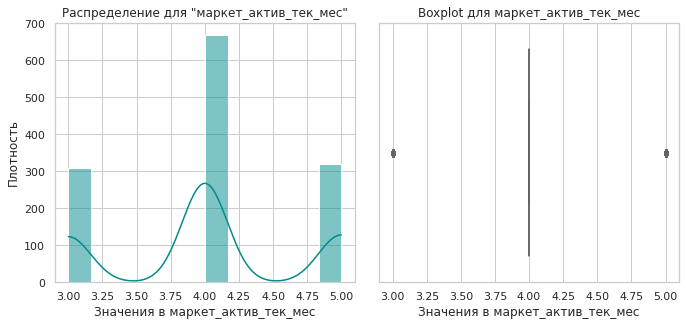

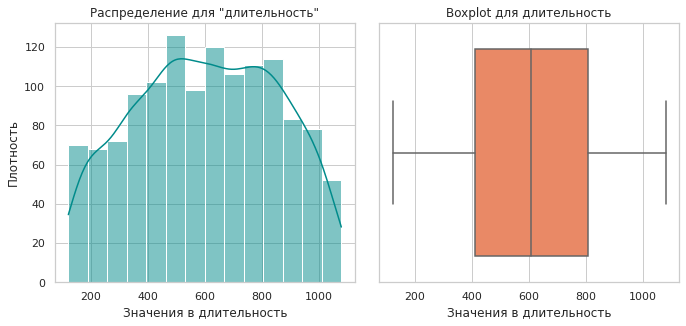

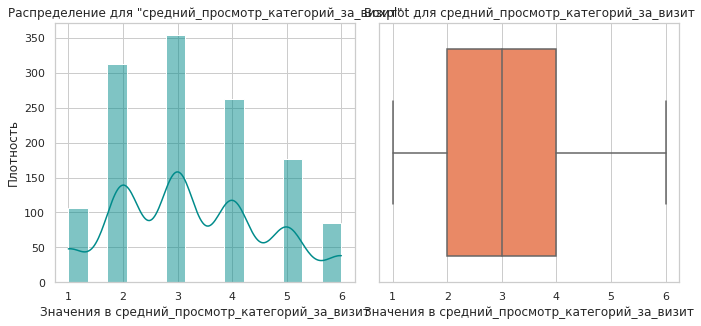

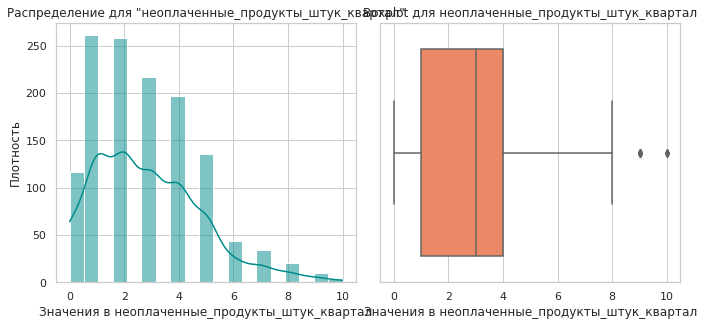

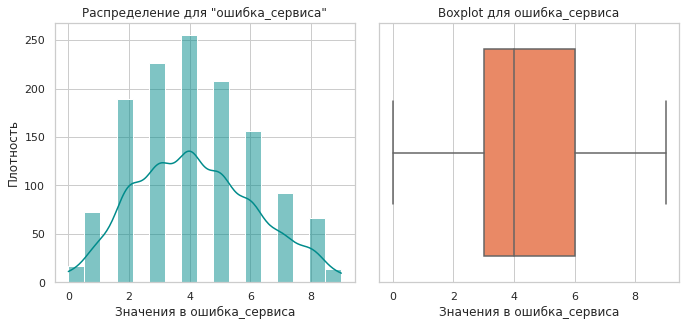

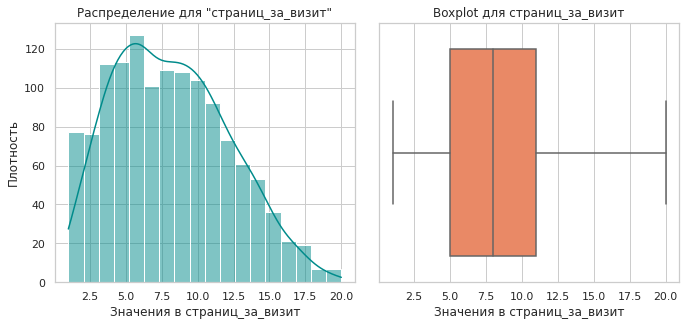

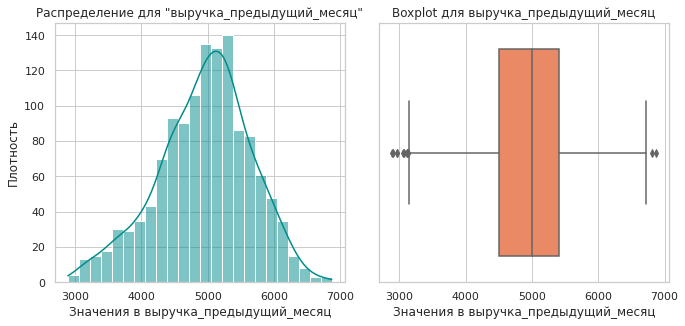

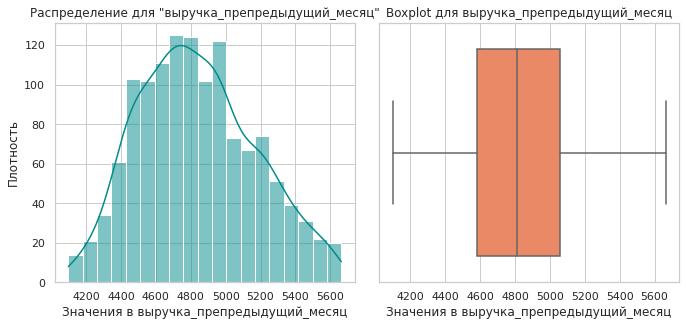

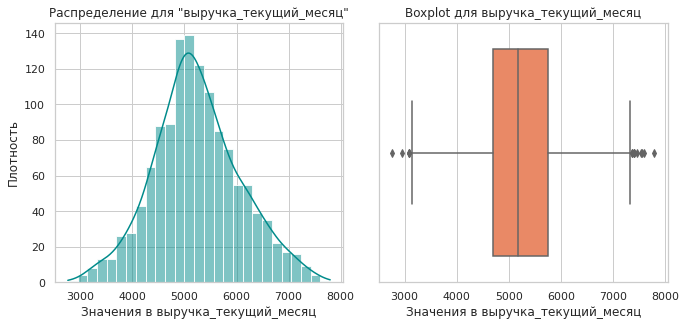

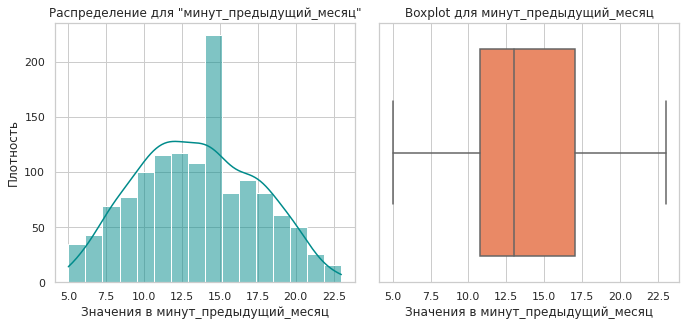

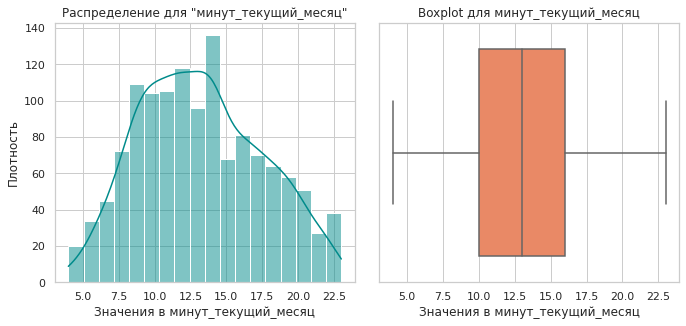

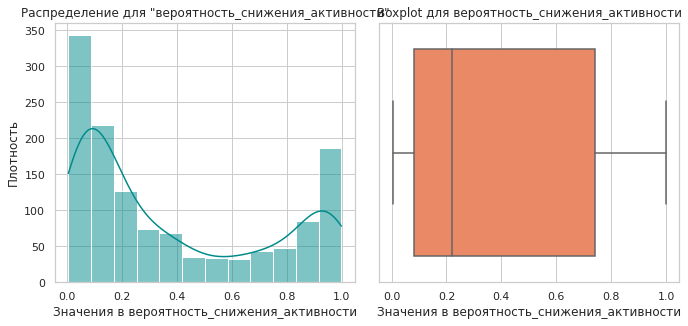

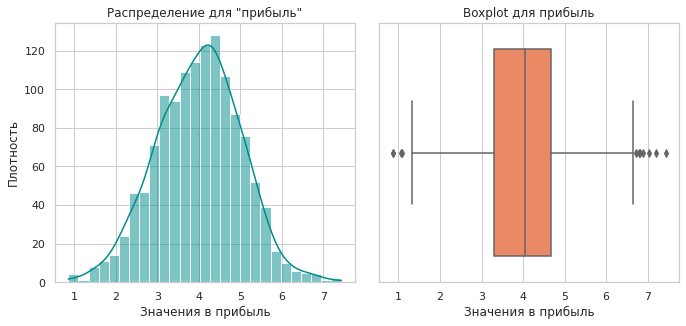

In [67]:
for name in num_df:
    plot_histogram_and_boxplot(df_combined, name)

**Из анализа графиков можно сделать вывод, что покупательская активность за последние 6 месяцев имеет более нормальное распределение, в то время как активность в текущем месяце заметно снизилась. Это говорит о потере интереса клиентов, могу предложить повысить активность маркетинговых коммуникаций, увеличение рекламных кампаний и персонализированных предложений для поддержания интереса у пользователей, чья активность снизилась в текущем месяце.**

**Количество просматриваемых категорий за визит также показывает интересное разделение на тех, кто выбирает товары быстро, и тех, кто тратит больше времени на изучение ассортимента. Для обеих групп можно предложить более персонализированные рекомендации, чтобы расширить их выбор.**

**Кроме того, значительное количество неоплаченных товаров в корзине говорит о том, что пользователи часто оставляют покупки незавершенными. Напоминания о забытых товарах и дополнительные скидки могли бы помочь ускорить принятие решения о покупке. Пользователи, которые часто совершают покупки по акции, остаются важной целевой аудиторией для предложений с большими скидками.**

# Итоговый вывод
**Загрузка данных:**
- **Все таблицы полностью заполнены, пропусков нет, что указывает на целостность предоставленных данных. Проверка типов данных показала, что они соответствуют требуемым для каждой колонки. Но стоит изменить названия столбцов, чтобы они были более удобные, для этого — все названия будут приведены к нижнему регистру. Кроме того, важно убедиться в отсутствии явных и неявных дубликатов в данных.**

**Предобработка данных:**
- **В ходе первоначального анализа данных, мы обнаружили 11 неявных дубликатов, которые отличаются только значениями в столбце id, остальные данные у них идентичны. Явных дубликатов не найдено, а названия столбцов успешно приведены к стандартному виду. В настоящий момент, решено оставить эти неявные дубликаты в датасете для дальнейшего анализа.**

**Исследовательский анализ:**
- **Изначальные данные были достаточно качественными, но все же потребовали некоторых изменений перед началом анализа. Во-первых, нужно было стандартизировать названия признаков. Во-вторых проведена проверка на дубликаты — в датасете market_file было найдено 11 дублирующихся строк (без учета уникальных идентификаторов) однако было решено их оставить**

**Обучение модели:**
- **С использованием пайпланов из библиотеки sklearn были обучены модели KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC(). При обучении моделей средствами пайплайна преебирались некоторое количество гиперпараметров моделей с целью нахождения модели, которая даст лучший результат. По результатам обучения лучшей стала модель LogisticRegression(C=1, penalty='l1', random_state=42, solver='liblinear'). Метрика roc_auc для тренеровочной выборки 0.89 для тестовой 0.92.**

**Анализ важности признаков:**
- **У выбранной модели была проанализирована важность признаков. Признаки, такие как "Косметика и аксессуары", "Домашний текстиль", "Товары для детей", а также наличие согласия на рассылку в категории "нет" и тип сервиса "премиум" оказывают наименьшее влияние на модель. Они не играют ключевой роли в прогнозировании снижения покупательской активности, и их можно рассматривать как второстепенные при принятии решений. Такие признаки, как наличие разрешения на рассылку, тип сервиса "стандарт", маркетинговая активность за последние шесть месяцев, текущий месяц, а также предыдущая выручка оказывают наибольшее влияние на прогнозирование. Это значит, что клиенты, которые активнее взаимодействовали с маркетинговыми кампаниями и имели положительную выручку, с меньшей вероятностью снизят свою покупательскую активность. Можно сосредоточить маркетинговые усилия на тех клиентах, которые дают согласие на рассылки и предлагают дополнительные преимущества для клиентов стандартного сервиса, чтобы удержать их активность.**

**Сегментация пользователей:**
- **Мое предложение по увеличение актвности этого сегмента покупателей это повысить активность маркетинговых коммуникаций, увеличение рекламных кампаний и персонализированных предложений для поддержания интереса у пользователей, чья активность снизилась в текущем месяце, а также напоминания о забытых товарах и дополнительные скидки могли бы помочь ускорить принятие решения о покупке товара оставшегося в корзине.**